In [5]:
import bluequbit
from qiskit.circuit.library import QFT

qft_circuit = QFT(num_qubits=5)
qft_circuit.measure_all()
token = 'lxT2BsygmI2P9zhfAXBF92a9MOGjztW5'
bq = bluequbit.init(token)
result = bq.run(qft_circuit, job_name="QFT on CPU")
print(result.get_counts().get("0"*5,0))

BQ-PYTHON-SDK - WARNING - Development version 0.7.0b1 of BlueQubit Python SDK is being used
BQ-PYTHON-SDK - INFO - Submitted: Job ID: hj0mVfAM9CNpKMot, name: QFT on CPU, device: cpu, run status: COMPLETED, created on: 2024-04-22 08:33:25 UTC, cost: $0.00, run time: 4 ms, queue time: 17 ms, num qubits: 5


0.03125


In [4]:
"0"*5

'00000'

Step: 100%|██████████| 10/10 [18:54<00:00, 113.45s/it]


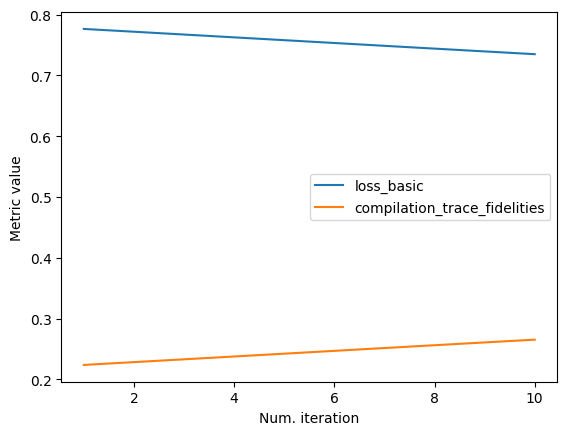

In [2]:
from qsee.compilation.qsp import QuantumStatePreparation
from qsee.core import ansatz, state
import qiskit
#define a custom ansatz
def custom_ansatz(num_qubits: int) -> qiskit.QuantumCircuit:
    qc = qiskit.QuantumCircuit(num_qubits)
    thetas = qiskit.circuit.ParameterVector(
        'theta', 2 * num_qubits)
    j = 0
    for i in range(num_qubits):
        qc.rx(thetas[j], i)
        qc.rz(thetas[j + 1], i)
        j += 2
    return qc    
#run the compiler  
num_qubits = 10
compiler = QuantumStatePreparation(
    u = custom_ansatz(num_qubits),
    target_state = state.w(num_qubits).inverse()
)

compiler.fit(
    num_steps = 10, 
    optimizer = 'sgd', 
    metrics_func = [
        'loss_basic', 
        'compilation_trace_fidelities'
    ],
    verbose = 1
)
#plot figure
compiler.plot()


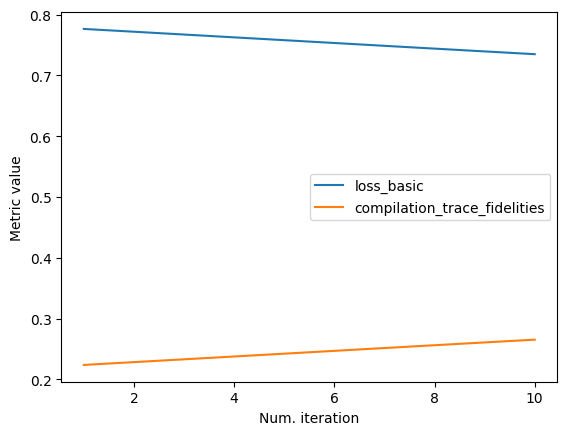

In [3]:
compiler.plot()

In [3]:
import sys, qiskit
sys.path.insert(0, '../../..')
import matplotlib.pyplot as plt
import numpy as np
import qsee
from qsee.compilation.qsp import QuantumStatePreparation
from qsee.core import ansatz, state, random_circuit
from qsee.backend import constant, utilities
from qsee.evolution import crossover, mutate, selection, threshold
from qsee.evolution.environment import EEnvironment, EEnvironmentMetadata
import pickle
import model
import os

times = np.linspace(0,10,50)

def compilation_fitness(qc: qiskit.QuantumCircuit):
    N=2
    J=1
    u=0
    h=[0,0]
    T=10
    def h_time(t):
        return model.XYZ_model(N,J,u,h,T,t)
    p0s = []
    for time in times:
        qsp = QuantumStatePreparation(
            u=qc,
            target_state=model.time_dependent_qc(N,h_time,time).inverse()
            ).fit(num_steps=50, metrics_func=['loss_basic'])
        p0s.append(1-qsp.compiler.metrics['loss_basic'][-1])
        time_folder = os.path.join(f"times_{num_qubits}/times= {time}")
        os.makedirs(time_folder, exist_ok=True)
        qsp.save(f"times_{num_qubits}/times= {times}")
        
    return np.mean(p0s)

def super_evol(_depth, _num_circuit, _num_generation):
    env_metadata = EEnvironmentMetadata(
        num_qubits = num_qubits,
        depth = _depth,
        num_circuit = _num_circuit,
        num_generation = _num_generation,
        prob_mutate=3/(_depth * _num_circuit)
    )
    env = EEnvironment(
        metadata = env_metadata,
        fitness_func= compilation_fitness,
        selection_func=selection.elitist_selection,
        crossover_func=crossover.onepoint_crossover,
        mutate_func=mutate.layerflip_mutate,
        threshold_func=threshold.compilation_threshold
    )
    env.set_filename(f'n={num_qubits},d={_depth},n_circuit={_num_circuit},n_gen={_num_generation}')
    env.evol()
    print('done')
    
# main
if __name__ == '__main__':
    num_qubits = 2
    super_evol(4,8,16)


ModuleNotFoundError: No module named 'model'